In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [8]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [ ]:
import math
import torch
import torch.nn as nn
from torch.autograd import Function

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0
        # print(mask.unique()) # Debugging line to check mask uniqueness

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Minimal DifferentiableKDE (batched only)
# ---------------------------
class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        super().__init__()
        self.register_buffer("x_eval", x_eval.view(-1))
        self.bandwidth = float(bandwidth)
        self.normalize = bool(normalize)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.x_eval.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        x = self.x_eval.view(M, 1, 1)
        s = samples.view(1, B, N)

        diffs = (x - s) / self.bandwidth
        kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi)

        w = weights.view(1, B, N)
        density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + 1e-12)

        density = density.permute(1, 0).contiguous()  # (B, M)

        if self.normalize:
            dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
            density /= (density.sum(dim=1, keepdim=True) * dx + 1e-12)

        return density  # (B, M)
    


class DifferentiableSoftHist(torch.nn.Module):
    def __init__(self, bin_centers, sigma, normalize=True):
        super().__init__()
        self.register_buffer("bin_centers", bin_centers.view(-1))
        self.sigma = float(sigma)
        self.normalize = normalize

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.bin_centers.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        # (B, N, M) assignment scores
        diffs = (samples.unsqueeze(-1) - self.bin_centers) / (self.sigma + 1e-12)
        assign = torch.exp(-0.5 * diffs**2)

        # weight and sum
        hist = (assign * weights.unsqueeze(-1)).sum(dim=1)  # (B, M)

        if self.normalize:
            hist = hist / (hist.sum(dim=1, keepdim=True) + 1e-12)

        return hist


# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval, kde_bandwidth=0.05):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=kde_bandwidth)
        # self.softhist = DifferentiableSoftHist(bin_centers=cos_theta_eval, )


    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_theta(cos_theta_lab, weights=valid)
    
# class ECSPipeline(nn.Module):
#     def __init__(self, E_eval, kde_bandwidth=0.3):
#         super().__init__()
#         self.simulator = NPReactionSimulator()
#         self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=kde_bandwidth)

#     def forward(self, Ek, r1, r2, r3):
#         Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
#         valid = (Ep_lab > 0).float()
#         return self.kde_E(Ep_lab, weights=valid)
    

# -------------------------------
# ACS autograd wrapper
# -------------------------------
# class NPACSSimulationFunction(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, Ek, r1, r2, r3, acs_pipeline: nn.Module):
#         """
#         Forward: runs ACS simulation pipeline
#         Inputs:
#             Ek: (B,)
#             r1,r2,r3: (B,N)
#             acs_pipeline: instance of ACSPipeline
#         Returns:
#             dsigma_dOmega: (B, M)
#         """
#         ctx.save_for_backward(r1, r2, r3, Ek)
#         ctx.pipeline = acs_pipeline

#         # Run pipeline
#         dsigma_dOmega = acs_pipeline(Ek, r1, r2, r3)  # (B, M)
#         return dsigma_dOmega

#     @staticmethod
#     def backward(ctx, grad_output):
#         r1, r2, r3, Ek = ctx.saved_tensors
#         B, N = r1.shape

#         # Simple straight-through surrogate gradient: broadcast grad_output to match r1/r2/r3
#         grad_r1 = grad_output.mean(dim=1, keepdim=True).expand_as(r1)
#         grad_r2 = grad_output.mean(dim=1, keepdim=True).expand_as(r2)
#         grad_r3 = grad_output.mean(dim=1, keepdim=True).expand_as(r3)

#         grad_Ek = None   # do not backprop through Ek
#         return grad_Ek, grad_r1, grad_r2, grad_r3, None

# # Helper wrapper
# def run_acs_autograd(Ek, r1, r2, r3, pipeline: ACSPipeline):
#     return NPACSSimulationFunction.apply(Ek, r1, r2, r3, pipeline)



# -------------------------------
# ECS autograd wrapper
# -------------------------------
# class NPECSSimulationFunction(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, Ek, r1, r2, r3, ecs_pipeline: nn.Module):
#         ctx.save_for_backward(r1, r2, r3, Ek)
#         ctx.pipeline = ecs_pipeline

#         dsigma_dE = ecs_pipeline(Ek, r1, r2, r3)  # (B, M)
#         return dsigma_dE

#     @staticmethod
#     def backward(ctx, grad_output):
#         r1, r2, r3, Ek = ctx.saved_tensors
#         B, N = r1.shape

#         # Straight-through surrogate gradient
#         grad_r1 = grad_output.mean(dim=1, keepdim=True).expand_as(r1)
#         grad_r2 = grad_output.mean(dim=1, keepdim=True).expand_as(r2)
#         grad_r3 = grad_output.mean(dim=1, keepdim=True).expand_as(r3)

#         grad_Ek = None
#         return grad_Ek, grad_r1, grad_r2, grad_r3, None

# # Helper wrapper
# def run_ecs_autograd(Ek, r1, r2, r3, pipeline: ECSPipeline):
#     return NPECSSimulationFunction.apply(Ek, r1, r2, r3, pipeline)


In [10]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# EPS = 1e-12

# class NPReactionSimulatorSmooth(nn.Module):
#     def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46,
#                  mask_k=20.0, softplus_beta=1.0):
#         """
#         mask_k: steepness for smooth mask sigmoid(mask_k * available_E)
#         softplus_beta: parameter for softplus inside e.g. softplus(x, beta)
#         """
#         super().__init__()
#         self.register_buffer("m_n", torch.tensor(float(m_n)))
#         self.register_buffer("m_p", torch.tensor(float(m_p)))
#         self.register_buffer("M_A", torch.tensor(float(M_A)))
#         self.register_buffer("S_n", torch.tensor(float(S_n)))
#         self.register_buffer("S_p", torch.tensor(float(S_p)))

#         self.mask_k = float(mask_k)
#         self.softplus_beta = float(softplus_beta)

#     def forward(self, Ek, r1, r2, r3):
#         # Ek: (B,) or (B,1) or (B,N) accepted; r1,r2,r3: (B,N)
#         if Ek.dim() == 1:
#             Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
#         elif Ek.shape[1] == 1:
#             Ek = Ek.expand(-1, r1.shape[1])

#         m_n = self.m_n.to(Ek)
#         m_p = self.m_p.to(Ek)
#         M_A = self.M_A.to(Ek)
#         S_n = self.S_n.to(Ek)
#         S_p = self.S_p.to(Ek)

#         # ---- physics-ish intermediate quantities (made smooth) ----
#         denom = (M_A + m_n) ** 2 + EPS
#         Tk = (Ek ** 2) * m_n / denom              # transfer-like term (small)

#         Ex = Ek - Tk + S_n
#         available_E = Ex - S_p                    # can be negative in physics, but smooth mask handles it

#         # smooth mask (in (0,1), differentiable)
#         mask = torch.sigmoid(self.mask_k * available_E)  # (B,N) soft indicator of available phase-space

#         # Make r1 meaningfully affect Ep_com even if available_E small:
#         # use a shifted fraction in [min_frac, 1.0]
#         min_frac = 0.05
#         frac = min_frac + (1.0 - min_frac) * r1     # (B,N)
#         Ep_com = frac * torch.nn.functional.softplus(available_E)  # use softplus so available_E -> positive smoothly

#         # E_p_com and p_mag_com: keep softplus inside sqrt to avoid clamping
#         E_p_com = Ep_com + m_p
#         inside = E_p_com**2 - m_p**2
#         inside_pos = F.softplus(inside, beta=self.softplus_beta)  # positive and smooth
#         p_mag_com = torch.sqrt(inside_pos + EPS)

#         # r2 is expected in [-1,1]; ensure it's slightly contracted to avoid exact +/-1
#         cos_theta_com = r2.clamp(-0.999, 0.999)    # small clamp preserves gradient
#         sin_theta_sq = F.softplus(1.0 - cos_theta_com**2, beta=self.softplus_beta)
#         sin_theta_com = torch.sqrt(sin_theta_sq + EPS)

#         # phi already in [-pi, pi]; use directly
#         phi = r3

#         px_com = p_mag_com * sin_theta_com * torch.cos(phi)
#         py_com = p_mag_com * sin_theta_com * torch.sin(phi)
#         pz_com = p_mag_com * cos_theta_com

#         # smooth "beta" (avoid hard clamp)
#         M_recoil = M_A + m_n
#         # make beta in (0, 1) smoothly; Tk/(M_recoil) might be tiny -> use scaled tanh
#         beta_raw = Tk / (M_recoil + EPS)
#         beta = 0.9999 * torch.tanh(beta_raw)   # smooth, |beta| < 1
#         gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-6))

#         # lab frame
#         E_lab = gamma * (E_p_com + beta * pz_com)
#         pz_lab = gamma * (pz_com + beta * E_p_com)

#         # magnitude with safe sqrt
#         p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + EPS)

#         # Ep_lab: use mask smoothly; avoid hard zeroing
#         Ep_lab_raw = E_lab - m_p
#         Ep_lab = mask * Ep_lab_raw + (1.0 - mask) * 1e-6  # tiny positive fallback where no phase-space

#         # cos_theta_lab: safe division
#         cos_theta_lab = pz_lab / (p_mag_lab + EPS)
#         # clamp to [-1,1] softly
#         cos_theta_lab = cos_theta_lab.clamp(-1.0 + 1e-6, 1.0 - 1e-6)

#         return Ep_lab, cos_theta_lab


# class DifferentiableKDE(nn.Module):
#     def __init__(self, x_eval, bandwidth=0.05, normalize=True):
#         super().__init__()
#         self.register_buffer("x_eval", x_eval.view(-1))
#         self.bandwidth = float(bandwidth)
#         self.normalize = bool(normalize)
#         self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

#     def forward(self, samples, weights=None):
#         # samples: (B, N)
#         B, N = samples.shape
#         M = self.x_eval.numel()

#         if weights is None:
#             weights = torch.ones_like(samples)

#         # shape tricks: (M, B, N)
#         x = self.x_eval.view(M, 1, 1)
#         s = samples.view(1, B, N)

#         diffs = (x - s) / (self.bandwidth + EPS)
#         kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi + EPS)

#         w = weights.view(1, B, N)
#         density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + EPS)  # (M, B)

#         density = density.permute(1, 0).contiguous()  # (B, M)

#         if self.normalize:
#             dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
#             density = density / (density.sum(dim=1, keepdim=True) * dx + EPS)

#         return density  # (B, M)
        


# class ACSPipelineSmooth(nn.Module):
#     def __init__(self, cos_theta_eval, kde_bandwidth=0.05, mask_k=20.0, softplus_beta=1.0):
#         super().__init__()
#         self.simulator = NPReactionSimulatorSmooth(mask_k=mask_k, softplus_beta=softplus_beta)
#         self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=kde_bandwidth)

#     def forward(self, Ek, r1, r2, r3):
#         Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
#         # use Ep_lab as soft weights (so every sample contributes, but weighted)
#         weights = torch.sigmoid(50.0 * (Ep_lab - 1e-4))  # near 1 if Ep_lab significantly positive, smooth otherwise
#         return self.kde_theta(cos_theta_lab, weights=weights)


In [11]:
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# pipeline = ACSPipelineSmooth(cos_theta_exp, kde_bandwidth=0.05).to(device)

# B, N, d = 64, 10, 3
# t = torch.rand(B, N, d, requires_grad=True)  # uniform [0,1]
# r1 = t[:, :, 0]
# r2 = t[:, :, 1] * 2 - 1   # maps to [-1,1]
# r3 = t[:, :, 2] * 2 * math.pi - math.pi  # maps to [-pi, pi]

# Ek = torch.full((B,), 5.0)  # example kinetic energy
# dsigma = pipeline(Ek, r1, r2, r3)

# dsigma_sum = dsigma.sum()  # simple scalar to backprop
# dsigma_sum.backward()

# grad_abs = t.grad.abs()  # (B, N, d)
# grad_std = grad_abs.view(B*N, d).std(0)
# grad_mean = grad_abs.view(B*N, d).mean(0)

# print("per-dimension grad mean:", grad_mean)
# print("per-dimension grad std:", grad_std)


# import matplotlib.pyplot as plt

# plt.hist(r1.view(-1).detach().numpy(), bins=20, weights=grad_abs[:,:,0].view(-1).detach().numpy())
# plt.title("Weighted histogram for r1")
# plt.show()





In [29]:
# import torch
# import math
# import matplotlib.pyplot as plt
# import numpy as np

# # --- from your data ---
# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Parameters
# B = len(E_inc_unique)  # one batch per experimental incoming energy
# N = 2000               # MC samples per Ek

# # Expand energies to batch
# Ek_batch = E_inc_unique.to(device)  # shape [B]

# # Random Monte Carlo parameters
# r1 = torch.rand((B, N), device=device)
# r2 = torch.rand((B, N), device=device) * 2 - 1
# r3 = torch.rand((B, N), device=device) * 2 * math.pi - math.pi
# r4 = torch.rand((B, N), device=device)

# # Create pipeline
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)
# # pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3, r4)  # shape [B, M]

# print("dsigma shape:", dsigma.shape)

# # Plot results
# fig, axes = plt.subplots(1, B, figsize=(4 * B, 4), sharey=False)
# if B == 1:
#     axes = [axes]

# for i, ax in enumerate(axes):
#     ax.plot(cos_theta_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     # ax.plot(E_sec_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     # ax.set_title(f"E_k = {Ek_batch[i].item():.2f} MeV")
#     ax.set_xlabel(r"$\cos\theta$")
#     if i == 0:
#         ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (arb. units)")

# plt.tight_layout()
# plt.show()


In [30]:
# # TESTING 
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# Ek_batch = torch.tensor([70.0], device=device)  # Example single energy, shape [B]

# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)

# dsigma

In [12]:
import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8, mse_weight=0.00001):

    # print(f"simulated_ddcs: {simulated_ddcs.shape}, experimental_ddcs: {experimental_ddcs.shape}")
    # KL (shape)
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    # print(f"sim_sum: {sim_sum.shape}, exp_sum: {exp_sum.shape}")

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    # print(f"sim_dist: {sim_dist.sum()}, exp_dist: {exp_dist.sum()}")

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    kl = F.kl_div(sim_dist.log(), exp_dist, reduction='batchmean', log_target=False)

    # MSE (scale)
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine
    loss = kl + mse_weight * mse_sums
    return loss


def wasserstein_1d_loss(mc_samples: torch.Tensor, exp_samples: torch.Tensor):
    """
    Compute 1D Wasserstein (Earth Mover's) distance between two sample tensors.
    Both tensors should be 1D: (batch_size,)
    """
    # Sort samples
    mc_sorted, _ = torch.sort(mc_samples)
    exp_sorted, _ = torch.sort(exp_samples)
    
    # Pad smaller tensor if needed (optional)
    n_mc = mc_sorted.shape[0]
    n_exp = exp_sorted.shape[0]
    if n_mc != n_exp:
        # Simple linear interpolation to match sizes
        exp_sorted = torch.interp(
            torch.linspace(0, 1, steps=n_mc, device=mc_samples.device),
            torch.linspace(0, 1, steps=n_exp, device=mc_samples.device),
            exp_sorted
        )
    
    # Wasserstein distance: average absolute difference
    loss = torch.mean(torch.abs(mc_sorted - exp_sorted))
    return loss


def diversity_loss(t):
    # scale each output dim to mean=0, std=1 before measuring diversity
    t_centered = t - t.mean(dim=1, keepdim=True)
    return -t_centered.std(dim=1).mean()


In [13]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 64 #2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 1024
epochs      = 1000 #0   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    # layers += [nn.Linear(d, n_out)]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)

E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# f_layer   = NPACSSimulationLayer(cos_theta_eval=cos_theta_exp).to(device) 
# f_layer   = NPECSSimulationLayer(E_eval=E_sec_exp).to(device)

optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [14]:
from tqdm import trange

# ---------------------------
# Create ACS/ECS simulation layer (autograd-friendly)
# ---------------------------
E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)

all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)
# all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, dist_len)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

# ==== Debug toggles ====
USE_FIXED_IDX = False         # True = always use the same idx for Ek
FIXED_IDX_VALUE = 5          # which dataset entry to use if above is True
USE_FIXED_MC = False         # True = use the same MC samples each epoch

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

net.train()
for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx]           # (B,)
    dsigma_dOmega_exp = all_exp[idx] # (B, M)

    # ----- MC samples -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Network forward -----
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
    net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

    t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)
    t.retain_grad()

    r1 = t[:, :, 0]
    r2 = t[:, :, 1] * 2 - 1
    r3 = t[:, :, 2] * 2 * torch.pi #- torch.pi

    # ----- ACS forward pass -----
    # dsigma_dOmega_sim = run_acs_autograd(Ek_batch, r1, r2, r3, acs_pipeline)  # (B, M)
    dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)
    # print(dsigma_dOmega_sim)
    # dsigma_dOmega_sim = run_acs_autograd(Ek_batch, r1, r2, r3, r4, acs_pipeline)  # (B, M)

    # print(f"dsigma_dOmega_sim: {dsigma_dOmega_sim.shape}, dsigma_dOmega_exp: {dsigma_dOmega_exp.shape}")

    # ----- Loss -----
    physics_loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
    div_loss = diversity_loss(t)

    # Combine
    lambda_div = 0.01
    loss = physics_loss + lambda_div * div_loss

    # ----- Backprop -----
    optimiser.zero_grad()
    loss.backward()

    # g = t.grad                # t from net(...).reshape(B,N,d) and requires_grad=True
    # print("per-sample grad std:", g.view(-1, g.shape[-1]).std(0))

    optimiser.step()

    if epoch % 100 == 0:
        # print(t.std(dim=1, keepdim=True).mean())
        # print(uniform_samples, t)
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")

    # t = torch.rand(1, 10, 3, requires_grad=True)
    # r1 = t[:,:,0]
    # r2 = t[:,:,1] * 2 - 1
    # r3 = t[:,:,2] * 2 * torch.pi - torch.pi
    # Ek = torch.full((1,), 65, requires_grad=False)

    # out = acs_pipeline(Ek, r1, r2, r3)
    # loss = out.mean()
    # loss.backward()

    # print(t.grad.abs().mean(), t.grad.std())



    # logits = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in)
    # logits.retain_grad()
    # target = torch.rand_like(logits)
    # loss_test = ((logits - target)**2).mean()
    # optimiser.zero_grad()
    # loss_test.backward()
    # print("logits.grad mean abs (sanity):", logits.grad.abs().mean().item())


# net.train()
# for epoch in trange(epochs, desc='Training Epochs'):

#     # ----- Index selection -----
#     if USE_FIXED_IDX:
#         idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
#     else:
#         idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

#     Ek_batch = all_Ek[idx]           # (B,)
#     dsigma_dE_exp = all_exp[idx]     # (B, M)  <- ECS experimental data

#     # ----- MC samples -----
#     if USE_FIXED_MC:
#         uniform_samples = fixed_uniform_samples
#     else:
#         uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

#     # ----- Network forward -----
#     Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
#     net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
#     net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

#     t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)

#     # Split seeds into r1,r2,r3 for the simulator
#     r1 = t[:, :, 0]
#     r2 = t[:, :, 1] * 2 - 1
#     r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

#     # ----- ECS forward pass -----
#     dsigma_dE_sim = run_ecs_autograd(Ek_batch, r1, r2, r3, ecs_pipeline)  # (B, M)

#     # ----- Loss -----
#     loss = kl_plus_sum_mse_loss(dsigma_dE_sim, dsigma_dE_exp)

#     # ----- Backprop -----
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")


Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs:   0%|          | 1/1000 [00:00<03:13,  5.15it/s]

tensor([True])
Epoch   1 | Loss: 11.657574
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   1%|          | 9/1000 [00:00<00:39, 24.84it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   2%|▏         | 17/1000 [00:00<00:35, 27.51it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   2%|▏         | 21/1000 [00:00<00:33, 29.43it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   3%|▎         | 29/1000 [00:01<00:31, 30.64it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   4%|▎         | 37/1000 [00:01<00:29, 32.45it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   4%|▍         | 45/1000 [00:01<00:27, 35.11it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   5%|▌         | 53/1000 [00:01<00:27, 34.11it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   6%|▌         | 61/1000 [00:01<00:26, 35.68it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   7%|▋         | 69/1000 [00:02<00:27, 33.26it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   7%|▋         | 73/1000 [00:02<00:27, 33.99it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   8%|▊         | 81/1000 [00:02<00:26, 35.25it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:   9%|▉         | 90/1000 [00:02<00:25, 35.66it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  10%|▉         | 98/1000 [00:03<00:25, 35.37it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  11%|█         | 106/1000 [00:03<00:25, 35.70it/s]

tensor([True])
Epoch 101 | Loss: 1.017722
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  11%|█▏        | 114/1000 [00:03<00:27, 32.64it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  12%|█▏        | 119/1000 [00:03<00:25, 34.44it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  13%|█▎        | 128/1000 [00:03<00:22, 38.05it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  14%|█▎        | 136/1000 [00:04<00:23, 36.70it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  14%|█▍        | 144/1000 [00:04<00:24, 34.40it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  15%|█▌        | 152/1000 [00:04<00:24, 34.54it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  16%|█▌        | 160/1000 [00:04<00:23, 35.55it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  16%|█▋        | 164/1000 [00:04<00:22, 36.37it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  17%|█▋        | 172/1000 [00:05<00:25, 31.92it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  18%|█▊        | 177/1000 [00:05<00:23, 34.51it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  19%|█▊        | 186/1000 [00:05<00:23, 35.06it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  19%|█▉        | 194/1000 [00:05<00:24, 32.38it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  20%|██        | 202/1000 [00:06<00:23, 33.45it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
Epoch 201 | Loss: 0.980011
tensor([True])


Training Epochs:  21%|██        | 206/1000 [00:06<00:22, 35.00it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  21%|██▏       | 214/1000 [00:06<00:24, 32.63it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  22%|██▏       | 218/1000 [00:06<00:28, 27.79it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  22%|██▏       | 224/1000 [00:06<00:27, 27.79it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  23%|██▎       | 232/1000 [00:07<00:23, 32.35it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  24%|██▍       | 240/1000 [00:07<00:22, 34.42it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  25%|██▍       | 249/1000 [00:07<00:20, 37.22it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  26%|██▌       | 257/1000 [00:07<00:20, 36.91it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  26%|██▋       | 265/1000 [00:07<00:19, 36.98it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  27%|██▋       | 269/1000 [00:08<00:22, 33.09it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  28%|██▊       | 277/1000 [00:08<00:23, 31.08it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  28%|██▊       | 285/1000 [00:08<00:22, 32.37it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  29%|██▉       | 289/1000 [00:08<00:22, 31.61it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  30%|██▉       | 297/1000 [00:08<00:22, 31.49it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  30%|███       | 305/1000 [00:09<00:20, 34.52it/s]

tensor([True])
Epoch 301 | Loss: 1.051051
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  31%|███▏      | 313/1000 [00:09<00:23, 28.77it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  32%|███▏      | 317/1000 [00:09<00:24, 27.43it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  32%|███▏      | 324/1000 [00:09<00:22, 29.66it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  33%|███▎      | 332/1000 [00:10<00:20, 32.67it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  34%|███▍      | 342/1000 [00:10<00:17, 37.06it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  35%|███▌      | 350/1000 [00:10<00:17, 38.12it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  35%|███▌      | 354/1000 [00:10<00:16, 38.14it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  36%|███▌      | 362/1000 [00:10<00:18, 34.18it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  37%|███▋      | 366/1000 [00:11<00:21, 29.84it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  38%|███▊      | 375/1000 [00:11<00:19, 31.34it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  38%|███▊      | 383/1000 [00:11<00:19, 31.97it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  39%|███▉      | 391/1000 [00:11<00:18, 32.78it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  40%|███▉      | 395/1000 [00:11<00:19, 31.70it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  40%|████      | 403/1000 [00:12<00:17, 34.08it/s]

tensor([True])
tensor([True])
tensor([True])
Epoch 401 | Loss: 1.083823
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  41%|████      | 411/1000 [00:12<00:17, 33.30it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  42%|████▏     | 419/1000 [00:12<00:16, 34.88it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  43%|████▎     | 427/1000 [00:12<00:16, 34.17it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  43%|████▎     | 431/1000 [00:13<00:16, 33.53it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  44%|████▍     | 439/1000 [00:13<00:19, 29.37it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  44%|████▍     | 444/1000 [00:13<00:17, 31.25it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  45%|████▍     | 448/1000 [00:13<00:21, 26.19it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  45%|████▌     | 454/1000 [00:13<00:21, 25.85it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  46%|████▌     | 461/1000 [00:14<00:19, 27.29it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  47%|████▋     | 467/1000 [00:14<00:20, 26.13it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  47%|████▋     | 474/1000 [00:14<00:18, 28.51it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  48%|████▊     | 480/1000 [00:14<00:18, 27.71it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  49%|████▊     | 486/1000 [00:15<00:19, 25.86it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  49%|████▉     | 493/1000 [00:15<00:18, 27.78it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  50%|█████     | 500/1000 [00:15<00:17, 29.00it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  50%|█████     | 504/1000 [00:15<00:16, 30.67it/s]

tensor([True])
Epoch 501 | Loss: 0.978327
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  51%|█████     | 512/1000 [00:15<00:15, 32.47it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  52%|█████▏    | 520/1000 [00:16<00:14, 33.26it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  52%|█████▏    | 524/1000 [00:16<00:15, 30.92it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  53%|█████▎    | 532/1000 [00:16<00:14, 31.95it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  54%|█████▍    | 540/1000 [00:16<00:13, 33.88it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  55%|█████▍    | 548/1000 [00:17<00:13, 33.00it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  55%|█████▌    | 552/1000 [00:17<00:13, 32.02it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  56%|█████▌    | 556/1000 [00:17<00:13, 33.81it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  56%|█████▋    | 563/1000 [00:17<00:17, 24.43it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  57%|█████▋    | 570/1000 [00:17<00:15, 27.28it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  58%|█████▊    | 576/1000 [00:18<00:15, 27.04it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  58%|█████▊    | 583/1000 [00:18<00:14, 28.45it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  59%|█████▉    | 590/1000 [00:18<00:13, 30.24it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  60%|█████▉    | 597/1000 [00:18<00:13, 29.22it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  60%|██████    | 605/1000 [00:19<00:12, 30.61it/s]

tensor([True])
Epoch 601 | Loss: 0.954223
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  61%|██████    | 609/1000 [00:19<00:12, 32.18it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  62%|██████▏   | 617/1000 [00:19<00:14, 27.20it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  62%|██████▏   | 623/1000 [00:19<00:14, 26.89it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  63%|██████▎   | 626/1000 [00:19<00:14, 25.52it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  63%|██████▎   | 632/1000 [00:20<00:14, 25.77it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  64%|██████▎   | 635/1000 [00:20<00:14, 25.66it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  64%|██████▍   | 641/1000 [00:20<00:16, 21.70it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  65%|██████▍   | 647/1000 [00:20<00:15, 22.74it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  65%|██████▌   | 653/1000 [00:21<00:15, 23.05it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  66%|██████▌   | 656/1000 [00:21<00:16, 21.07it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  66%|██████▌   | 662/1000 [00:21<00:16, 20.56it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  66%|██████▋   | 665/1000 [00:21<00:15, 21.38it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  67%|██████▋   | 671/1000 [00:21<00:15, 21.53it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  67%|██████▋   | 674/1000 [00:22<00:14, 22.18it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  68%|██████▊   | 680/1000 [00:22<00:13, 23.83it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  68%|██████▊   | 683/1000 [00:22<00:14, 22.18it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  69%|██████▊   | 686/1000 [00:22<00:15, 20.45it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  69%|██████▉   | 689/1000 [00:22<00:15, 19.83it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  69%|██████▉   | 694/1000 [00:23<00:18, 16.78it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  70%|██████▉   | 696/1000 [00:23<00:20, 14.85it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  70%|███████   | 700/1000 [00:23<00:20, 14.84it/s]

tensor([True])
tensor([True])
tensor([True])
Epoch 701 | Loss: 1.109310
tensor([True])


Training Epochs:  70%|███████   | 704/1000 [00:23<00:18, 16.20it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  71%|███████   | 708/1000 [00:24<00:18, 15.83it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  71%|███████   | 712/1000 [00:24<00:17, 16.77it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  71%|███████▏  | 714/1000 [00:24<00:18, 15.60it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  72%|███████▏  | 718/1000 [00:24<00:17, 15.74it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  72%|███████▏  | 722/1000 [00:24<00:17, 15.64it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  73%|███████▎  | 726/1000 [00:25<00:16, 16.96it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  73%|███████▎  | 730/1000 [00:25<00:15, 17.01it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  73%|███████▎  | 732/1000 [00:25<00:17, 15.14it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  74%|███████▎  | 736/1000 [00:25<00:18, 14.64it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  74%|███████▍  | 741/1000 [00:26<00:15, 17.08it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  75%|███████▍  | 747/1000 [00:26<00:12, 19.47it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  75%|███████▌  | 750/1000 [00:26<00:12, 20.26it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  76%|███████▌  | 756/1000 [00:26<00:11, 21.53it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  76%|███████▌  | 762/1000 [00:27<00:10, 22.64it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  76%|███████▋  | 765/1000 [00:27<00:10, 23.37it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  77%|███████▋  | 771/1000 [00:27<00:10, 22.01it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  77%|███████▋  | 774/1000 [00:27<00:10, 21.52it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  78%|███████▊  | 780/1000 [00:27<00:09, 22.75it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  79%|███████▊  | 786/1000 [00:28<00:10, 21.23it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  79%|███████▉  | 789/1000 [00:28<00:10, 19.50it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  79%|███████▉  | 792/1000 [00:28<00:11, 17.97it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  80%|███████▉  | 796/1000 [00:28<00:11, 18.24it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  80%|████████  | 801/1000 [00:28<00:10, 19.45it/s]

tensor([True])
tensor([True])
Epoch 801 | Loss: 1.001454
tensor([True])
tensor([True])


Training Epochs:  80%|████████  | 804/1000 [00:29<00:09, 19.84it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  81%|████████  | 809/1000 [00:29<00:11, 16.99it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  81%|████████▏ | 813/1000 [00:29<00:10, 17.58it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  82%|████████▏ | 820/1000 [00:30<00:08, 20.57it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  82%|████████▏ | 823/1000 [00:30<00:08, 21.14it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  83%|████████▎ | 826/1000 [00:30<00:08, 20.11it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  83%|████████▎ | 829/1000 [00:30<00:09, 17.65it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  83%|████████▎ | 833/1000 [00:30<00:10, 15.96it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  84%|████████▎ | 837/1000 [00:31<00:10, 16.01it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  84%|████████▍ | 839/1000 [00:31<00:10, 15.11it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  84%|████████▍ | 841/1000 [00:31<00:12, 12.97it/s]

tensor([True])
tensor([True])


Training Epochs:  84%|████████▍ | 843/1000 [00:31<00:14, 10.57it/s]

tensor([True])


Training Epochs:  85%|████████▍ | 846/1000 [00:32<00:19,  7.93it/s]

tensor([True])
tensor([True])


Training Epochs:  85%|████████▍ | 848/1000 [00:32<00:16,  9.25it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  85%|████████▌ | 852/1000 [00:32<00:12, 12.10it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  86%|████████▌ | 856/1000 [00:32<00:09, 14.55it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  86%|████████▌ | 858/1000 [00:32<00:08, 15.80it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  86%|████████▌ | 862/1000 [00:33<00:08, 15.76it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  87%|████████▋ | 867/1000 [00:33<00:07, 16.65it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  87%|████████▋ | 871/1000 [00:33<00:07, 17.01it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  88%|████████▊ | 875/1000 [00:33<00:07, 17.67it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  88%|████████▊ | 879/1000 [00:34<00:06, 17.45it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  88%|████████▊ | 883/1000 [00:34<00:06, 16.88it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  89%|████████▊ | 887/1000 [00:34<00:06, 17.11it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  89%|████████▉ | 889/1000 [00:34<00:06, 16.97it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  89%|████████▉ | 893/1000 [00:35<00:07, 15.08it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  90%|████████▉ | 897/1000 [00:35<00:07, 14.49it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  90%|████████▉ | 899/1000 [00:35<00:06, 14.55it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  90%|█████████ | 901/1000 [00:35<00:06, 14.36it/s]

tensor([True])
Epoch 901 | Loss: 1.015569
tensor([True])


Training Epochs:  90%|█████████ | 905/1000 [00:36<00:07, 12.24it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  91%|█████████ | 907/1000 [00:36<00:07, 12.37it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  91%|█████████ | 909/1000 [00:36<00:07, 12.72it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  91%|█████████▏| 913/1000 [00:36<00:06, 13.08it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  92%|█████████▏| 915/1000 [00:36<00:06, 13.49it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  92%|█████████▏| 919/1000 [00:37<00:06, 13.25it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  92%|█████████▏| 923/1000 [00:37<00:05, 13.87it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  92%|█████████▎| 925/1000 [00:37<00:05, 14.30it/s]

tensor([True])


Training Epochs:  93%|█████████▎| 927/1000 [00:37<00:06, 10.85it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  93%|█████████▎| 931/1000 [00:38<00:05, 11.80it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  94%|█████████▎| 935/1000 [00:38<00:04, 13.29it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  94%|█████████▍| 939/1000 [00:38<00:04, 13.66it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  94%|█████████▍| 941/1000 [00:38<00:04, 12.65it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  94%|█████████▍| 943/1000 [00:38<00:04, 11.94it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  94%|█████████▍| 945/1000 [00:39<00:04, 12.20it/s]

tensor([True])
tensor([True])


Training Epochs:  95%|█████████▍| 949/1000 [00:39<00:05, 10.09it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  95%|█████████▌| 951/1000 [00:39<00:04, 10.50it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  96%|█████████▌| 955/1000 [00:40<00:04, 11.24it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  96%|█████████▌| 957/1000 [00:40<00:03, 11.84it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  96%|█████████▌| 961/1000 [00:40<00:03, 12.37it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  96%|█████████▋| 963/1000 [00:40<00:03, 11.69it/s]

tensor([True])
tensor([True])


Training Epochs:  96%|█████████▋| 965/1000 [00:41<00:03,  9.65it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  97%|█████████▋| 969/1000 [00:41<00:02, 11.05it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  97%|█████████▋| 973/1000 [00:41<00:02, 12.19it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  98%|█████████▊| 975/1000 [00:41<00:01, 12.57it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  98%|█████████▊| 977/1000 [00:41<00:01, 12.87it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  98%|█████████▊| 981/1000 [00:42<00:01, 12.82it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  98%|█████████▊| 983/1000 [00:42<00:01, 12.96it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs:  99%|█████████▊| 987/1000 [00:42<00:01, 10.78it/s]

tensor([True])
tensor([True])
tensor([True])
tensor([True])


Training Epochs:  99%|█████████▉| 991/1000 [00:43<00:00, 12.04it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs: 100%|█████████▉| 995/1000 [00:43<00:00, 12.91it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs: 100%|█████████▉| 997/1000 [00:43<00:00, 13.37it/s]

tensor([True])
tensor([True])
tensor([True])


Training Epochs: 100%|██████████| 1000/1000 [00:43<00:00, 22.81it/s]

tensor([True])
tensor([True])


In [15]:
net.eval()
with torch.no_grad():
    Ek = all_Ek[:1]                             # one condition
    u1 = torch.rand(1, 256, n_in, device=device)
    u2 = torch.rand(1, 256, n_in, device=device)

    x1 = torch.cat([u1, Ek[:, None, None].expand(-1, 256, 1)], dim=-1).reshape(-1, n_in+1)
    x2 = torch.cat([u2, Ek[:, None, None].expand(-1, 256, 1)], dim=-1).reshape(-1, n_in+1)

    t1 = net(x1).reshape(1, 256, n_in)
    t2 = net(x2).reshape(1, 256, n_in)

print("mean |t1 - t2|:", (t1 - t2).abs().mean().item())

mean |t1 - t2|: 0.0019982976373285055


In [15]:
# # ======== Hyperparameters ========
# lambda_div_max = 0.1   # max weight for diversity term
# div_ramp_epochs = 50   # linearly increase lambda_div over first div_ramp_epochs

# # ======== Training loop ========
# net.train()
# for epoch in trange(epochs, desc='Training Epochs'):

#     # ----- Index selection -----
#     if USE_FIXED_IDX:
#         idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
#     else:
#         idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

#     Ek_batch = all_Ek[idx]           # (B,)
#     dsigma_dOmega_exp = all_exp[idx] # (B, M)

#     # ----- MC samples -----
#     if USE_FIXED_MC:
#         uniform_samples = fixed_uniform_samples
#     else:
#         uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

#     # ----- Network forward -----
#     Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
#     net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
#     net_input_flat = net_input.reshape(-1, n_in + 1)

#     logits = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in)  # (B, N, n_in)

#     # ----- Transform logits to simulator inputs -----
#     t_mapped = torch.sigmoid(logits)
#     r1 = t_mapped[:, :, 0]
#     r2 = t_mapped[:, :, 1] * 2 - 1
#     r3 = t_mapped[:, :, 2] * 2 * torch.pi - torch.pi

#     dsigma_dOmega_sim = run_acs_autograd(Ek_batch, r1, r2, r3, acs_pipeline)

#     # ----- Physics loss -----
#     loss_physics = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

#     # ----- Diversity loss (normalized) -----
#     t_centered = logits - logits.mean(dim=1, keepdim=True)
#     t_norm = t_centered / (t_centered.std(dim=1, keepdim=True) + 1e-6)
#     loss_div = -t_norm.std(dim=1).mean()  # maximize relative std

#     # ----- Ramp up lambda_div -----
#     lambda_div = lambda_div_max * min(10, epoch / div_ramp_epochs)

#     # ----- Total loss -----
#     loss = loss_physics + lambda_div * loss_div

#     # ----- Backprop -----
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     if epoch % 100 == 0:
#         print(epoch / div_ramp_epochs)

#         print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f} | λ_div={lambda_div:.4f}")


tensor([True])


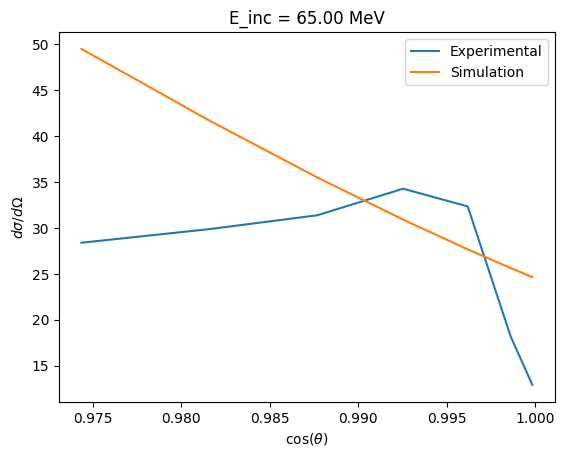

tensor([True])


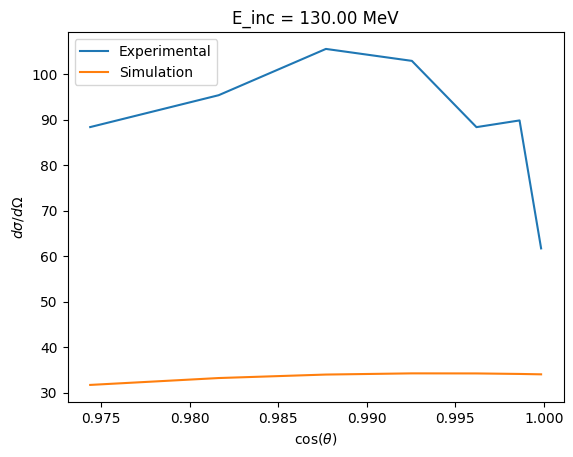

tensor([True])


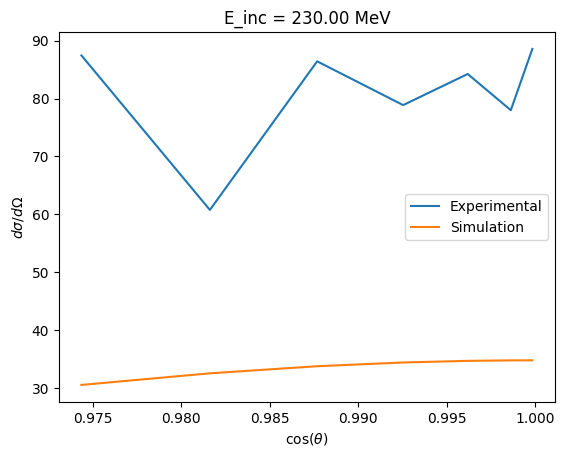

In [16]:
import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 2000
monitor_indices = [0, len(integrated_results) // 2, -1]  # pick a few energies


for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6  # scalar tensor

    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
    # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, 3)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1] * 2 - 1
        r3 = t[:, :, 2] * 2 * torch.pi #- torch.pi

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)
        # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)


    # Plot
    plt.figure()
    plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_exp.cpu(), sim_dist.cpu(), label='Simulation')
    plt.xlabel(r'$\cos(\theta)$')

    # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
    # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
    plt.legend()
    plt.show()
